# Trabalho de reconhecimento de padrões
+ Implementar o algoritmo C4.5 de Árvore de Decisão para classificar o banco de dados fornecido
+ No algoritmo C4.5, você deve usar a entropia (ganho de informação) como critério de escolha dos nós
+ Não é necessário realizar as podas
+ Usar validação cruzada K-fold com K=10
+ Você deve escolher os atributos que achar mais convenientes
+ Deve-se usar pelo menos 4 atributos.

# Imports necessários

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import random
import warnings
warnings.filterwarnings('ignore')

# Carregar base de dados

In [2]:
dados = pd.read_csv('https://raw.githubusercontent.com/SamuelHericles/Arvore_decisao/master/wine.csv')
dados

,Classes,c1,c2,c3,c4,c5,c6,c7,c8,c9,c10,c11,c12,c13
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,3,13.71,5.65,2.45,20.5,95,1.68,0.61,0.52,1.06,7.70,0.64,1.74,740
174,3,13.40,3.91,2.48,23.0,102,1.80,0.75,0.43,1.41,7.30,0.70,1.56,750
175,3,13.27,4.28,2.26,20.0,120,1.59,0.69,0.43,1.35,10.20,0.59,1.56,835
176,3,13.17,2.59,2.37,20.0,120,1.65,0.68,0.53,1.46,9.30,0.60,1.62,840


# Escolhas dos atributos

In [3]:
atributos = pd.DataFrame({})
atributos['Classes']  = dados['Classes'] 
atributos['media']    = dados.iloc[:,1:].mean(axis='columns')
atributos['mediana']  = dados.iloc[:,1:].median(axis='columns')
atributos['max']      = dados.iloc[:,1:].max(axis='columns')  
atributos['var']      = dados.iloc[:,1:].var(axis='columns')
atributos

,Classes,media,mediana,max,var
0,1,95.769231,3.06,1065.0,85970.564441
1,1,91.853846,2.76,1050.0,83597.745276
2,1,103.216923,3.17,1185.0,106377.417356
3,1,126.960769,3.49,1480.0,166185.467008
4,1,69.899231,2.87,735.0,40942.531674
...,...,...,...,...,...
173,3,68.558462,2.45,740.0,41352.920031
174,3,69.903077,2.48,750.0,42514.372123
175,3,77.786154,2.26,835.0,52806.453142
176,3,77.997692,2.37,840.0,53466.127136


# Plotagem dos atributos

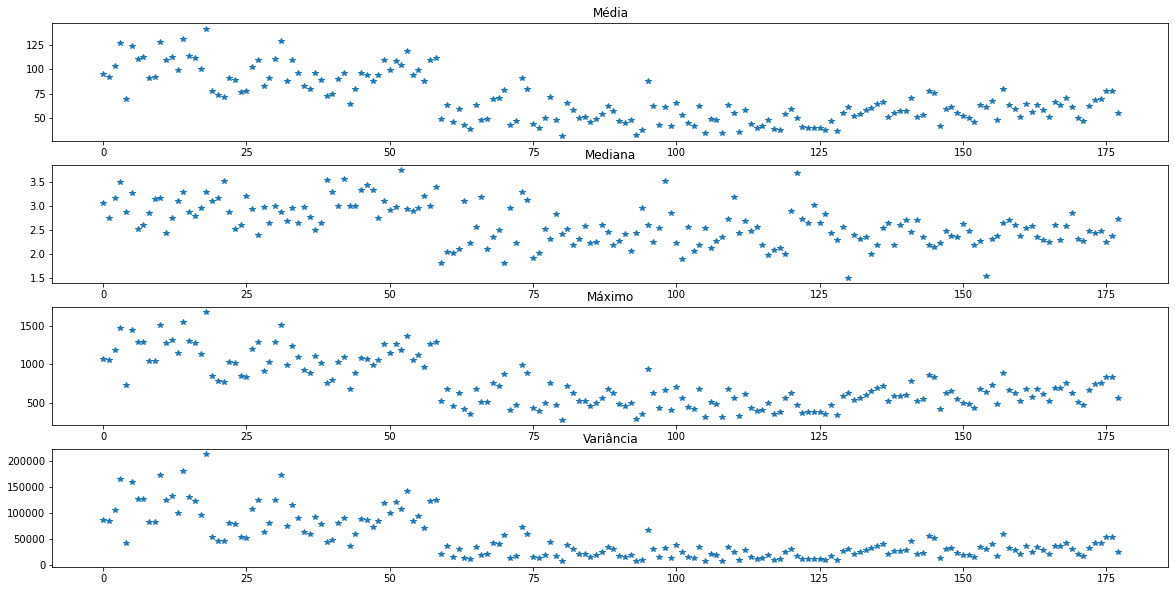

In [4]:
ax = plt.figure(figsize=(20,10))

ax = plt.subplot(411)
ax = plt.title('Média')
ax = plt.plot(atributos['media'],'*')

ax = plt.subplot(412)
ax = plt.title('Mediana')
ax = plt.plot(atributos['mediana'],'*')

ax = plt.subplot(413)
ax = plt.title('Máximo')
ax = plt.plot(atributos['max'],'*')

ax = plt.subplot(414)
ax = plt.title('Variância')
ax = plt.plot(atributos['var'],'*')

plt.show()

# Conforme dito, vamos remover uma classe

In [5]:
atributos.drop(atributos.query('Classes==3').index,inplace=True)
atributos

,Classes,media,mediana,max,var
0,1,95.769231,3.06,1065.0,85970.564441
1,1,91.853846,2.76,1050.0,83597.745276
2,1,103.216923,3.17,1185.0,106377.417356
3,1,126.960769,3.49,1480.0,166185.467008
4,1,69.899231,2.87,735.0,40942.531674
...,...,...,...,...,...
125,2,39.559231,2.65,378.0,10866.315941
126,2,37.790000,2.84,352.0,9450.335583
127,2,47.409231,2.44,466.0,16449.428774
128,2,37.196923,2.30,342.0,8959.165456


# Divide os dados de treino e teste com Kfold shuffle estratificado

In [6]:
# @param base  base dados da situação
# return X     base de treino
# return y     base de teste 
def kfold_shuffle_estratificado(base):
    # Pegar a quantidade de dados que a classe 1 tem
    Classe1 = base.query('Classes==1')
    Classe1.reset_index(drop=True,inplace=True)

    # Pegar a quantidade de dados que a classe 2 tem
    Classe2 = base.query('Classes==2')
    Classe2.reset_index(drop=True,inplace=True)

    # Dividir os dados de treino e teste da classe 1
    index_teste_classe_1 = sorted(random.sample([i for i in Classe1.index.values],int(Classe1.shape[0]*.1)+1))
    X_classe_1 = Classe1.iloc[[i for i in Classe1.index if i not in index_teste_classe_1],:]
    y_classe_1 = Classe1.iloc[index_teste_classe_1,:]

    # Dividir os dados de treino e teste da classe 2
    index_teste_classe_2 = sorted(random.sample([i for i in Classe2.index.values],int(Classe2.shape[0]*.1)))
    X_classe_2 = Classe2.iloc[[i for i in Classe2.index if i not in index_teste_classe_2],:]
    y_classe_2 = Classe2.iloc[index_teste_classe_2,:]

    # Juntar dados de Treino e teste das classes
    X = X_classe_1
    y = y_classe_1

    X = X.append(X_classe_2,ignore_index=True)
    y = y.append(y_classe_2,ignore_index=True)
    return X,y

# Entropia
$H = - \sum_{i=1}^{n} {p_i(x)logp_i(x)}$
# Ganho de informação
$GH = H_{raiz} - \sum{pesos}*H_{folha}$

$Pesos = \frac{Nº amostras da folha}{Nº amostras da raiz}$



In [7]:
# @param base       base de dados para entropia
# return entropia   entropia da base de atributos
def calcula_entropia(base):
    # Pega quantidade de amostras da classe 1
    qt_am_1 = base.query('Classes==1').shape[0]
    
    # Pega quantidade de amostras da classe 2
    qt_am_2 = base.query('Classes==2').shape[0]
    
    # Pega o tamanho do vector de atributos
    qt_base = base.shape[0]
    
    # Calcula a probabilidade de cada classe
    probabilidade_1  = qt_am_1/qt_base
    probabilidade_2  = qt_am_2/qt_base
    
    # Calcula a entropia
    Entropia = -1*(probabilidade_1*math.log(probabilidade_1,2) + probabilidade_2*math.log(probabilidade_2,2))
    return Entropia

# @param folha          base de dados da folha
# @param entropia_pai   entropia da base de dados completa
# @param entropia_filho entropia do atributo especifíco
# return GH             ganho de informação
def ganho_de_informacao(folha,entropia_pai,entropia_filho):
    
    # Pega os pelos de cada classe e coloca neste veto
    Pesos = [folha.query('Classes==1').shape[0]/folha.shape[0],folha.query('Classes==2').shape[0]/folha.shape[0]]
    
    # Calcula o ganho de informação do nó filho
    GH = (Pesos[0]*entropia_filho + Pesos[1]*entropia_filho) - entropia_pai
    return GH

# Rotulagem da base dados pelo o limiar da mediana dos atributos

In [8]:
# @param base            base de dados de um atributo
# @param entropia_pai    entropia da base de dados da situação
# return GH              ganho de informação do atributo
# return limiar          limiar do atributo
def divide_pelo_limar(base,entropia_pai):
    
    # Cria um dataframe que pega a classe e o valor
    folha = pd.DataFrame(columns = {'Classes','Valor'})
    
    # Pega o limiar do atributo específico
    limiar = base.median()
    
    # Rotula os dados de teste a partir de cada limiar dos atributos
    for i in range(base.shape[0]):
         if base[i] > limiar:
                folha = folha.append({'Classes':1,'Valor':base[i]},
                                       ignore_index=True)
         elif base[i] <= limiar:
            folha = folha.append({'Classes':2,'Valor':base[i]},
                           ignore_index=True)

    # Após rotular os atributos calcula-se a entropia
    entropia_filho = calcula_entropia(folha)
    
    # Depois o ganho de informação
    GH = ganho_de_informacao(folha,entropia_pai,entropia_filho)
    
    return GH,limiar

# O algoritmo de árvore de descisão C4.5
1. Para cada atributo:

    1.1 Ordene os atributos da base de treinamento do atributo específico;
    
    1.2 Determinar os limiares $\theta$;
    
    1.3 Para cada limiar $\theta$, determine as informações entre $\theta$ e os atributos.
    
2. Escolha os pares [atributo,$\theta$] que oferece o mais alto ganho de informação.


Fonte: slide disponivel pelo professor.

In [9]:
# @param X       base de treino
# @param y       base de teste
# return acurácia do modelo
def arvore_de_decisao_c45(X,y):
    
    # Pega a entropia da base de dados
    entropia_pai = calcula_entropia(X)
    
    # Cria o dataframe que armazena os ganhos
    GHs = pd.DataFrame(columns = {'GH','Limiar','Nome'})
    
    # Pegar os dados de informação de cada atributo
    for i in range(X.shape[1]-1):
        GH,divisor = divide_pelo_limar(X.iloc[:,i+1],entropia_pai)
        GHs = GHs.append({'GH':GH,'Limiar':divisor,'Nome':X.iloc[:,i+1].name},ignore_index=True)

    # Organiza os ganhos de informação em ordem descrecente
    GHs.sort_values('GH',ascending=False,inplace=True)
    GHs.reset_index(drop=True,inplace=True)
    
    # Retira os rótulos da base de teste
    y_pred = y.iloc[:,1:]
    y_pred['Classes_pred'] = 0
    
    # Rótular os dados da base de teste com base nos limiares escolhidos a partir do ganho de informação
    for i in range(GHs.shape[0]):
        for j in range(y_pred.shape[0]):
            
            # Se o ganho de informação não for zero ou negativo, tá valendo
            # Aqui seria uma espécia de poda da árvore
            if GHs['GH'][i] > 0:
                
                # Vai rotulando e substituindo do atributo de melhor ganho de informação para o pior
                if y_pred[GHs['Nome'][i]][j] >= GHs['Limiar'][i]:
                    y_pred['Classes_pred'][j] = 1
                else:
                    y_pred['Classes_pred'][j] = 2

    # Cacula acurácia do modelo específico
    return (sum(y_pred['Classes_pred'] == y['Classes'])/y.shape[0])*100

# Execução do algoritmo

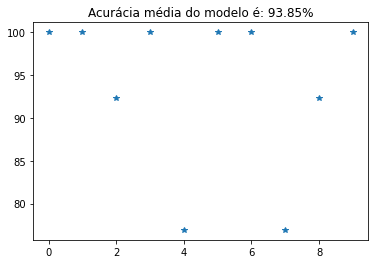

In [13]:
# Vetor de acurácias
accs = []

# Cálcula várias vezes base de dados diferentes com árvore de descição
for i in range(10):
    X,y = kfold_shuffle_estratificado(atributos)
    accs.append(arvore_de_decisao_c45(X,y))

# Plota cada resultado junto com a acurácia média do modelo
plt.title(f'Acurácia média do modelo é: {np.mean(accs).round(2)}%')
plt.plot(accs,'*')
plt.show()

# Teste com sklearn

Acurácia média 94.09


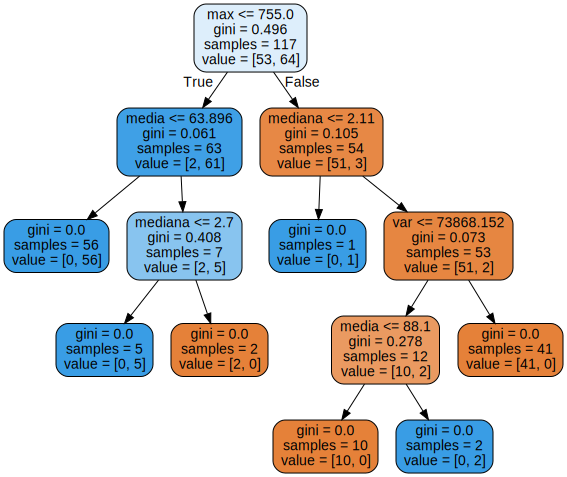

In [11]:
from sklearn import tree
from sklearn.model_selection import cross_validate
import graphviz
from sklearn.tree import export_graphviz
from sklearn.model_selection import GroupKFold

clf = tree.DecisionTreeClassifier()
results = cross_validate(clf, X.iloc[:,1:], X['Classes'], cv=10, return_train_score=False)
cv = GroupKFold(n_splits=10)
def imprime_resultados(results):
    media = results['test_score'].mean()*100
    print('Acurácia média %.2f' % media)
imprime_resultados(results)

features = X.columns[1:]
clf.fit(X.iloc[:,1:], X['Classes'])
dot_data = export_graphviz(clf, out_file = None, filled = True,
                rounded = True,
                feature_names = features)

# Temos 10 modelos (cv = 10)
graph = graphviz.Source(dot_data)
graph